# First part of the analysis: Dennison and Ogilvie
In this notebook, all scripts and graphs necesaary to conduct an analysis of the data as Dennison and Ogilvie does is present.

In [2]:
# Load in packages and data
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv')
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv')

df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_4183/3333189222.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')


# SMAM

In [5]:


def create_smam_visualizations(temporal_stats, county_names):
    """
    Create visualizations for SMAM analysis comparing male and female patterns
    with international county names and highlighting specific years
    """
    # County name mapping for international audience
    county_map = {
        'københavn': 'Copenhagen',
        'århus': 'Aarhus',
        'odense': 'Odense'
    }
    
    # Set up figure for comparison
    fig, axes = plt.subplots(len(county_names), 1, figsize=(12, 5*len(county_names)), sharex=True)
    if len(county_names) == 1:
        axes = [axes]  # Make sure axes is always a list
    
    # Color palette
    colors = {'female': '#FF69B4', 'male': '#1E90FF'}
    
    for i, county in enumerate(county_names):
        ax = axes[i]
        int_county_name = county_map.get(county, county)
        
        # Plot female SMAM
        female_data = temporal_stats[(temporal_stats['county'] == county) & 
                                    (temporal_stats['gender'] == 'female')]
        if not female_data.empty:
            ax.plot(female_data['year'], female_data['smam'], 
                   marker='o', color=colors['female'], label='Female SMAM')
        
        # Plot male SMAM
        male_data = temporal_stats[(temporal_stats['county'] == county) & 
                                  (temporal_stats['gender'] == 'male')]
        if not male_data.empty:
            ax.plot(male_data['year'], male_data['smam'], 
                   marker='s', color=colors['male'], label='Male SMAM')
        
        # Add SMAM gap visualizations (connecting lines) where both genders have data
        if not female_data.empty and not male_data.empty:
            # Find years with data for both genders
            female_years = set(female_data['year'])
            male_years = set(male_data['year'])
            common_years = sorted(female_years.intersection(male_years))
            
            for year in common_years:
                female_smam = female_data[female_data['year'] == year]['smam'].values[0]
                male_smam = male_data[male_data['year'] == year]['smam'].values[0]
                gap = male_smam - female_smam
                
                # Draw a vertical line connecting male and female points
                ax.plot([year, year], [female_smam, male_smam], color='gray', linestyle='-', alpha=0.7)
                
                # Annotate the gap
                mid_point = (female_smam + male_smam) / 2
                ax.annotate(f"{gap:.1f}", 
                           xy=(year, mid_point),
                           xytext=(5, 0), textcoords='offset points',
                           fontsize=9, ha='left')
        
        # Highlight Copenhagen 1834 with a vertical line and annotation
        if county == 'københavn':
            highlight_year = 1834
            ymin, ymax = ax.get_ylim()
            ax.axvline(x=highlight_year, color='red', linestyle='--', alpha=0.7)
            ax.annotate("A'", 
                       xy=(highlight_year, ymax),
                       xytext=(0, -10), textcoords='offset points',
                       fontsize=12, color='red', ha='center', va='top',
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        
        # Set up the plot
        ax.set_title(f'SMAM Comparison - {int_county_name}')
        ax.set_ylabel('Age (years)')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best')
    
    # Set up common x-axis label
    axes[-1].set_xlabel('Year')
    plt.tight_layout()
    
    # Create a second figure for gender gap analysis
    gap_fig, gap_ax = plt.subplots(figsize=(12, 6))
    
    for county in county_names:
        int_county_name = county_map.get(county, county)
        
        # Calculate gender gap for each year
        county_data = temporal_stats[temporal_stats['county'] == county]
        years = []
        gaps = []
        
        for year in sorted(set(county_data['year'])):
            female_smam = county_data[(county_data['year'] == year) & 
                                     (county_data['gender'] == 'female')]['smam']
            male_smam = county_data[(county_data['year'] == year) & 
                                   (county_data['gender'] == 'male')]['smam']
            
            if not female_smam.empty and not male_smam.empty:
                years.append(year)
                gaps.append(male_smam.values[0] - female_smam.values[0])
        
        if years and gaps:
            gap_ax.plot(years, gaps, marker='o', label=int_county_name)
    
    # Highlight Copenhagen 1834 in the gap plot as well
    gap_ax.axvline(x=1834, color='red', linestyle='--', alpha=0.7)
    gap_ax.annotate("A'", 
                   xy=(1834, gap_ax.get_ylim()[1]),
                   xytext=(0, -10), textcoords='offset points',
                   fontsize=12, color='red', ha='center', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
    
    gap_ax.set_title('Gender Gap in SMAM (Male - Female)')
    gap_ax.set_xlabel('Year')
    gap_ax.set_ylabel('Age Difference (years)')
    gap_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    gap_ax.grid(True)
    gap_ax.legend()
    
    return fig, gap_fig

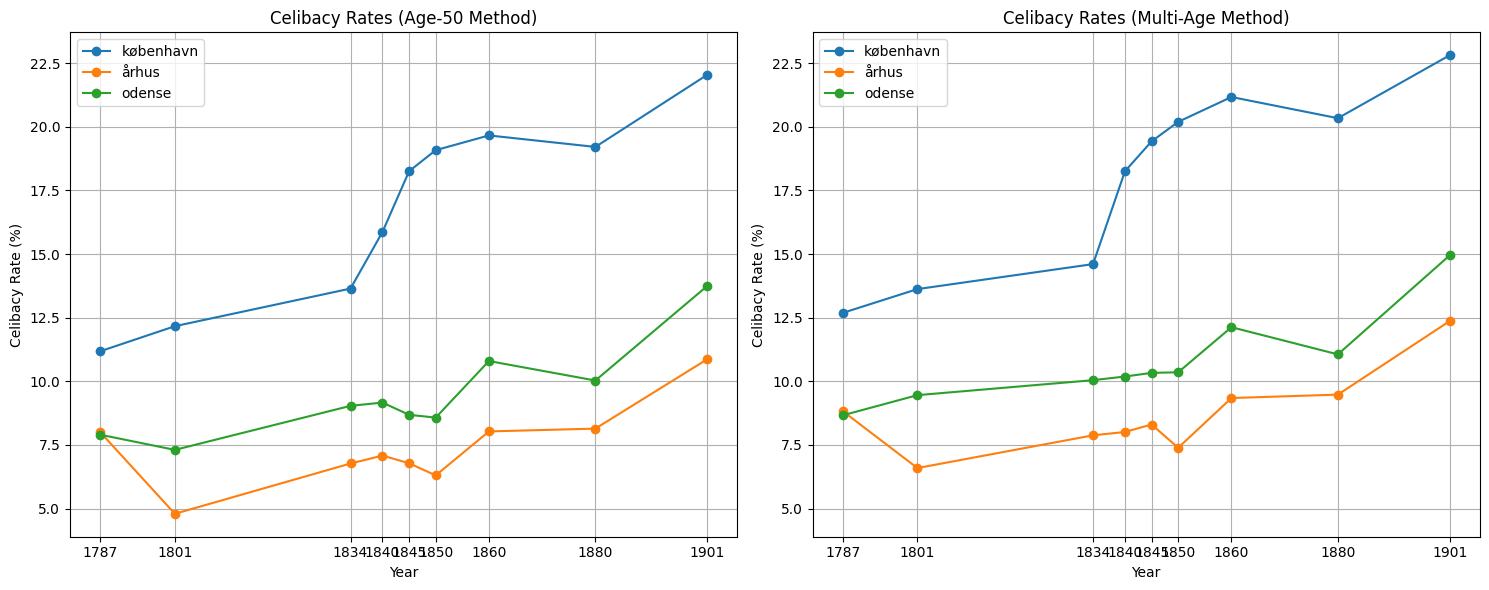

In [10]:
import matplotlib.pyplot as plt
# methods for calculating the estimate lifetime celibacy of women
def celibacy_age_50(data):
    """
    Calculate celibacy rate using women aged 45-54. Simular to Hajnal's method
    """
    late_age_women = data[(data['age'] >= 45) & (data['age'] <= 54)]
    return len(late_age_women[late_age_women['marital_status'] == 'ugift']) / len(late_age_women)

def celibacy_multi_age(data):
    """
    Calculate celibacy using multiple age windows (40-44, 45-49, 50-54)
    and take weighted average
    """
    celibacy_rates = []
    weights = []
    
    for age_start in [40, 45, 50]:
        age_group = data[(data['age'] >= age_start) & (data['age'] < age_start + 5)]
        if len(age_group) > 0:
            rate = len(age_group[age_group['marital_status'] == 'ugift']) / len(age_group)
            celibacy_rates.append(rate)
            weights.append(len(age_group))
    
    return np.average(celibacy_rates, weights=weights)

def celibacy_cohort(data):
    """
    Track same birth cohorts across multiple censuses
    """
    cohort_rates = {}
    
    for year in data['event_year'].unique():
        birth_years = year - data[data['event_year'] == year]['age']
        for cohort in birth_years.unique():
            cohort_data = data[year - data['age'] == cohort]
            if len(cohort_data) > 0:
                cohort_rates[cohort] = len(cohort_data[cohort_data['marital_status'] == 'ugift']) / len(cohort_data)
    
    return cohort_rates

def celibacy_regional(data):
    """
    Calculate rates by county and compare to identify patterns
    """
    regional_rates = {}
    
    for county in data['event_county'].unique():
        county_data = data[data['event_county'] == county]
        late_age = county_data[(county_data['age'] >= 45) & (county_data['age'] <= 54)]
        if len(late_age) > 0:
            regional_rates[county] = len(late_age[late_age['marital_status'] == 'ugift']) / len(late_age)
    
    return regional_rates

def analyze_celibacy_rates(df_list, county_names):
    """
    Comprehensive analysis of celibacy rates using multiple methods
    """
    # Combine all dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Filter for women only
    women_df = combined_df[combined_df['sex'] == 'f'].copy()
    
    results = {}
    
    # Calculate rates for each county and year
    for county in county_names:
        county_data = women_df[women_df['event_county'] == county]
        results[county] = {}
        
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            if len(year_data) > 0:
                results[county][year] = {
                    'age_50': celibacy_age_50(year_data),
                    'multi_age': celibacy_multi_age(year_data),
                    'sample_size': len(year_data),
                    'age_45_54_sample': len(year_data[(year_data['age'] >= 45) & 
                                                     (year_data['age'] <= 54)])
                }
    
    # Calculate cohort rates if multiple years available
    cohort_results = {}
    if len(women_df['event_year'].unique()) > 1:
        for county in county_names:
            county_data = women_df[women_df['event_county'] == county]
            cohort_results[county] = celibacy_cohort(county_data)
    
    return results, cohort_results

def print_celibacy_analysis(results, cohort_results):
    """
    Print celibacy analysis results in a clearly structured format
    """
    print("=== FEMALE LIFETIME CELIBACY ANALYSIS ===\n")
    
    # Print county-specific results
    for county, county_data in results.items():
        print(f"\n{county.upper()}")
        print("=" * len(county))
        
        print("\nYearly Analysis:")
        print("Year  | Age-50 Method | Multi-Age Method | Sample Size (45-54)")
        print("-" * 65)
        
        for year in sorted(county_data.keys()):
            data = county_data[year]
            print(f"{int(year)}  | "
                  f"{data['age_50']*100:^12.1f}% | "
                  f"{data['multi_age']*100:^14.1f}% | "
                  f"{data['age_45_54_sample']:^16d}")
        
        # Calculate averages
        avg_age_50 = np.mean([d['age_50'] for d in county_data.values()])
        avg_multi = np.mean([d['multi_age'] for d in county_data.values()])
        
        print("\nSummary Statistics:")
        print(f"Average celibacy rate (Age-50 Method): {avg_age_50*100:.1f}%")
        print(f"Average celibacy rate (Multi-Age Method): {avg_multi*100:.1f}%")
        
        # Print cohort analysis if available
        if county in cohort_results and cohort_results[county]:
            print("\nCohort Analysis:")
            print("Birth Cohort | Celibacy Rate")
            print("-" * 30)
            
            for cohort, rate in sorted(cohort_results[county].items()):
                print(f"{int(cohort):^11d} | {rate*100:^12.1f}%")
    
    # Print cross-county comparison
    print("\n=== CROSS-COUNTY COMPARISON ===")
    print("\nAverage Celibacy Rates:")
    print("County | Age-50 Method | Multi-Age Method")
    print("-" * 45)
    
    for county, county_data in results.items():
        avg_age_50 = np.mean([d['age_50'] for d in county_data.values()])
        avg_multi = np.mean([d['multi_age'] for d in county_data.values()])
        print(f"{county:^6s} | {avg_age_50*100:^12.1f}% | {avg_multi*100:^14.1f}%")

def create_celibacy_visualization(results: dict) -> plt.Figure:
    """
    Create visualizations of celibacy rates with normalized y-axes
    and x-axis labels only for years with data.
    
    Args:
        results: Dictionary containing celibacy analysis results
        
    Returns:
        matplotlib Figure object with the visualizations
    """
    # Prepare data for plotting
    plot_data = []
    for county, county_data in results.items():
        for year, data in county_data.items():
            plot_data.append({
                'County': county,
                'Year': year,
                'Age-50 Rate': data['age_50'] * 100,
                'Multi-Age Rate': data['multi_age'] * 100
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Get all unique years in the data
    available_years = sorted(plot_df['Year'].unique())
    
    # Find global min and max for y-axis normalization
    y_min = min(plot_df['Age-50 Rate'].min(), plot_df['Multi-Age Rate'].min())
    y_max = max(plot_df['Age-50 Rate'].max(), plot_df['Multi-Age Rate'].max())
    
    # Add a small buffer to the y-range (5% of the range)
    y_buffer = (y_max - y_min) * 0.05
    y_min = max(0, y_min - y_buffer)  # Don't go below 0 for rates
    y_max = y_max + y_buffer
    
    # Plot Age-50 rates
    for county in plot_df['County'].unique():
        county_data = plot_df[plot_df['County'] == county]
        ax1.plot(county_data['Year'], county_data['Age-50 Rate'], 
                marker='o', label=county)
    
    ax1.set_title('Celibacy Rates (Age-50 Method)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Celibacy Rate (%)')
    ax1.set_ylim(y_min, y_max)  # Set normalized y-axis
    ax1.set_xticks(available_years)  # Only show years with data
    ax1.legend()
    ax1.grid(True)
    
    # Plot Multi-Age rates
    for county in plot_df['County'].unique():
        county_data = plot_df[plot_df['County'] == county]
        ax2.plot(county_data['Year'], county_data['Multi-Age Rate'], 
                marker='o', label=county)
    
    ax2.set_title('Celibacy Rates (Multi-Age Method)')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Celibacy Rate (%)')
    ax2.set_ylim(y_min, y_max)  # Set normalized y-axis
    ax2.set_xticks(available_years)  # Only show years with data
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

results, cohort_analysis = analyze_celibacy_rates(df_list, county_names)
fig = create_celibacy_visualization(results)

=== SINGULATE MEAN AGE AT MARRIAGE (SMAM) ANALYSIS ===

Analysis Period: 1787-1901

FEMALE SMAM

KØBENHAVN
---------

Yearly Statistics:
Year  | SMAM  | Marriage Rate | Never Married Rate | Total Count
-----------------------------------------------------------------
1787  | 27.8 |     34.8      |       11.5        |    55082   
1801  | 28.1 |     33.6      |       11.5        |    61667   
1834  | 28.7 |     28.7      |       14.4        |    31469   
1840  | 30.1 |     26.5      |       16.1        |    81091   
1845  | 28.4 |     27.4      |       19.9        |    83460   
1850  | 28.8 |     28.7      |       20.5        |    88188   
1860  | 27.8 |     30.3      |       20.5        |   104147   
1880  | 26.9 |     30.8      |       19.9        |   166351   
1901  | 27.1 |     30.8      |       22.9        |   282465   

Trends and Summary:
SMAM Trend: -0.010 years/year
Mean SMAM: 28.2 years
Range: 26.9 - 30.1 years

ÅRHUS
-----

Yearly Statistics:
Year  | SMAM  | Marriage Rate | Ne

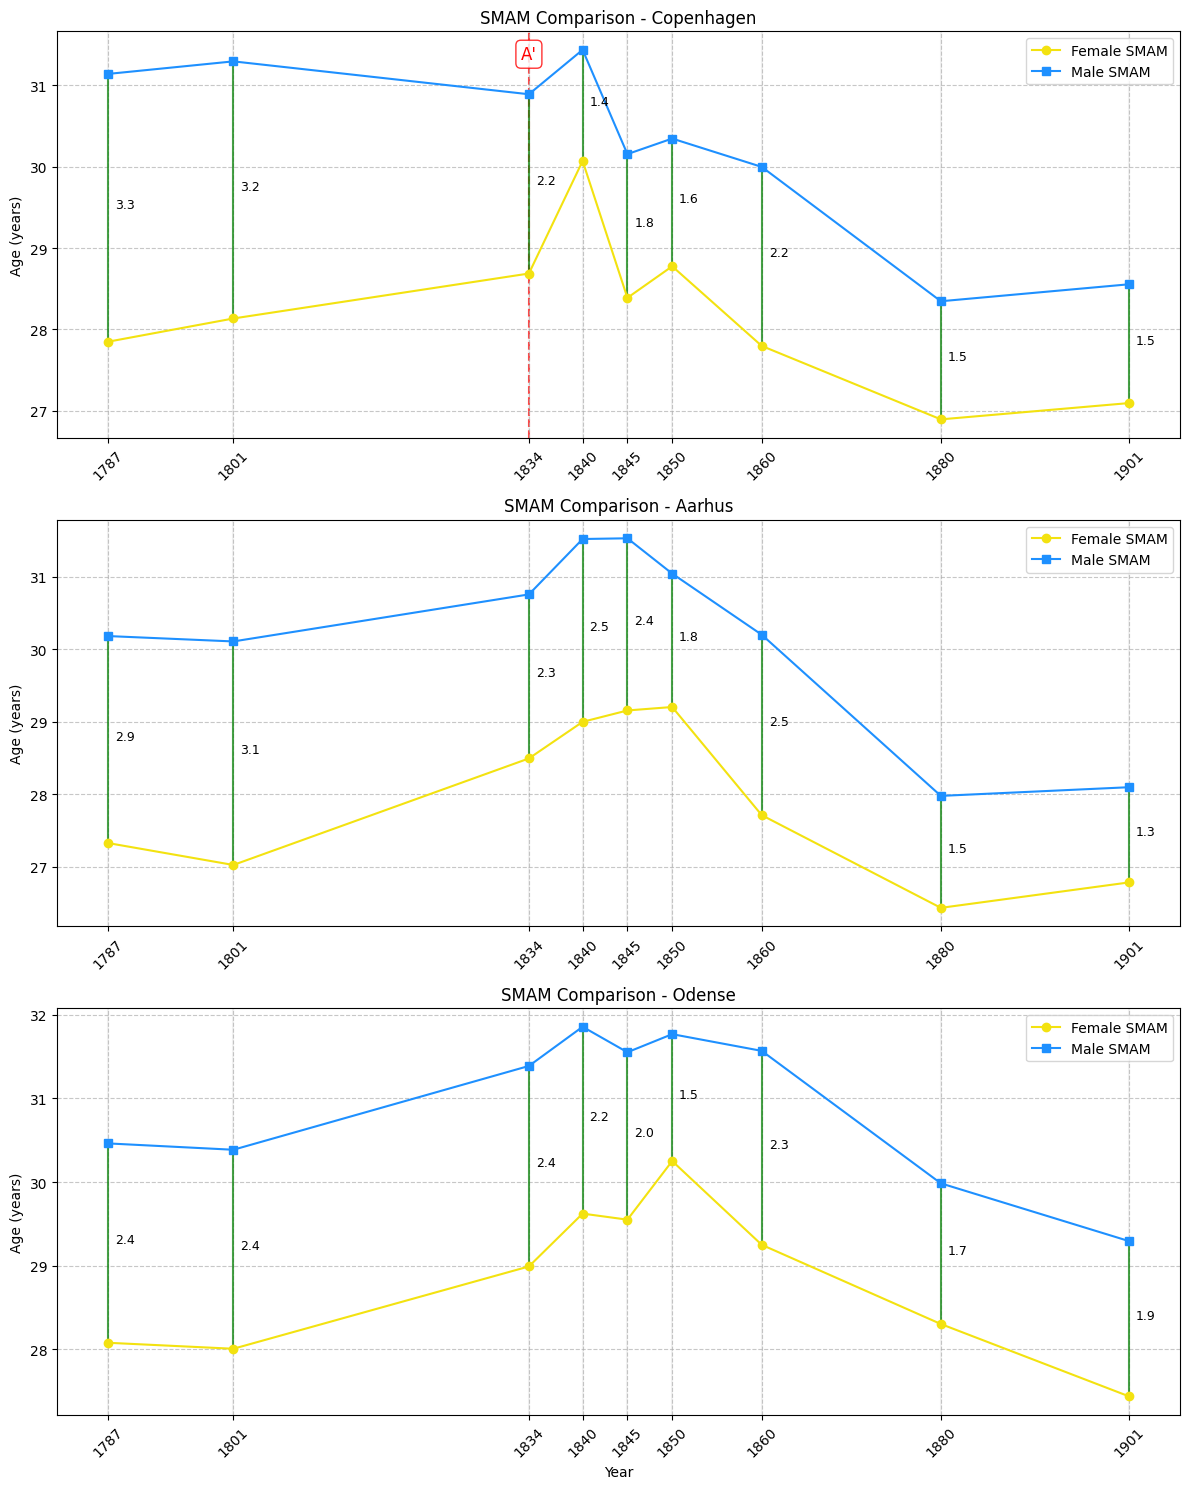

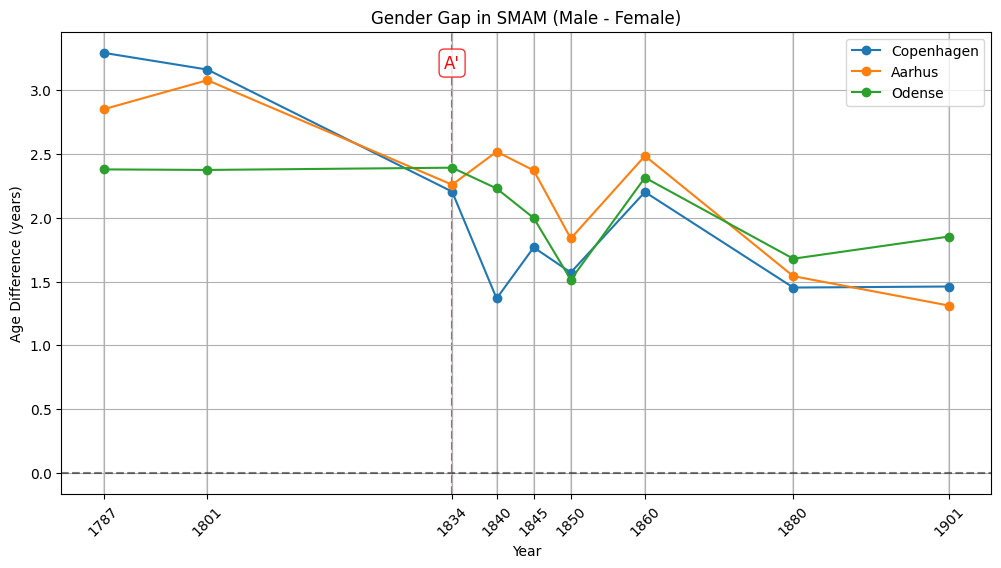

In [6]:
def calculate_SMAM(data, min_age=15, max_age=50, age_interval=5, gender=None):
    """
    Calculate Singulate Mean Age at Marriage following Hajnal's formula:
    SMAM = (15 + 5P - 50N) / (1-N)
    where:
    P = sum of proportions never married from age 15-19 to 45-49
    N = proportion never married at age 50
    
    Parameters:
    data: DataFrame with age and marital status
    gender: Optional filter for specific gender ('m' or 'f')
    """
    # Filter by gender if specified
    if gender is not None:
        data = data[data['sex'] == gender]
        
    # Calculate P: sum of proportions never married from 15-19 to 45-49
    P = 0
    for age_start in range(min_age, max_age, age_interval):
        age_end = age_start + age_interval
        age_group = data[(data['age'] >= age_start) & (data['age'] < age_end)]
        
        if len(age_group) > 0:
            prop_single = len(age_group[age_group['marital_status'] == 'ugift']) / len(age_group)
            P += prop_single
    
    # Calculate N: proportion never married at age 50
    age_50_group = data[(data['age'] >= 45) & (data['age'] < 50)]  # Using 45-49 as proxy for age 50
    if len(age_50_group) > 0:
        N = len(age_50_group[age_50_group['marital_status'] == 'ugift']) / len(age_50_group)
    else:
        return None, None
    
    # Calculate SMAM using Hajnal's formula
    if N < 1:  # Avoid division by zero
        smam = (15 + 5 * P - 50 * N) / (1 - N)
    else:
        return None, None
    
    stats = {
        'P': P,
        'N': N,
        'age_specific_proportions': {
            f"{age}-{age+4}": len(data[(data['age'] >= age) & 
                                     (data['age'] < age+5) & 
                                     (data['marital_status'] == 'ugift')]) / 
                              len(data[(data['age'] >= age) & 
                                     (data['age'] < age+5)])
            for age in range(15, 50, 5)
        },
        'final_celibacy': N
    }
    
    return smam, stats

def analyze_marriage_age_temporal_smam(df_list, county_names):
    """
    Analyze marriage patterns using SMAM across counties and time for both genders
    """
    # Combine all dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Initialize results storage
    temporal_results = []
    detailed_stats = {'female': {}, 'male': {}}
    
    # Analyze by county, year, and gender
    for county in county_names:
        county_data = combined_df[combined_df['event_county'] == county]
        detailed_stats['female'][county] = {}
        detailed_stats['male'][county] = {}
        
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            if len(year_data) == 0:
                continue
            
            # Calculate female SMAM
            women_data = year_data[year_data['sex'] == 'f']
            if len(women_data) > 0:
                female_smam, female_stats = calculate_SMAM(women_data)
                
                if female_smam is not None and female_stats is not None:
                    detailed_stats['female'][county][year] = female_stats
                    
                    total_women = len(women_data)
                    married_women = len(women_data[women_data['marital_status'] == 'gift'])
                    never_married = len(women_data[women_data['marital_status'] == 'ugift'])
                    widowed = len(women_data[women_data['marital_status'] == 'enke'])
                    
                    temporal_results.append({
                        'county': county,
                        'year': year,
                        'gender': 'female',
                        'smam': female_smam,
                        'total_count': total_women,
                        'married_count': married_women,
                        'never_married_count': never_married,
                        'widowed_count': widowed,
                        'marriage_rate': (married_women / total_women * 100) if total_women > 0 else 0,
                        'final_celibacy': female_stats['final_celibacy'] * 100
                    })
            
            # Calculate male SMAM
            men_data = year_data[year_data['sex'] == 'm']
            if len(men_data) > 0:
                male_smam, male_stats = calculate_SMAM(men_data)
                
                if male_smam is not None and male_stats is not None:
                    detailed_stats['male'][county][year] = male_stats
                    
                    total_men = len(men_data)
                    married_men = len(men_data[men_data['marital_status'] == 'gift'])
                    never_married = len(men_data[men_data['marital_status'] == 'ugift'])
                    widowed = len(men_data[men_data['marital_status'] == 'enke'])
                    
                    temporal_results.append({
                        'county': county,
                        'year': year,
                        'gender': 'male',
                        'smam': male_smam,
                        'total_count': total_men,
                        'married_count': married_men,
                        'never_married_count': never_married,
                        'widowed_count': widowed,
                        'marriage_rate': (married_men / total_men * 100) if total_men > 0 else 0,
                        'final_celibacy': male_stats['final_celibacy'] * 100
                    })
    
    # Convert results to DataFrame
    temporal_stats = pd.DataFrame(temporal_results)
    
    # Calculate trends by gender
    trends = {'female': {}, 'male': {}}
    for gender in ['female', 'male']:
        gender_data = temporal_stats[temporal_stats['gender'] == gender]
        
        for county in county_names:
            county_data = gender_data[gender_data['county'] == county]
            if not county_data.empty:
                try:
                    smam_trend = np.polyfit(county_data['year'], county_data['smam'], 1)[0]
                    trends[gender][county] = {
                        'smam_trend': smam_trend,
                        'mean_smam': county_data['smam'].mean(),
                        'min_smam': county_data['smam'].min(),
                        'max_smam': county_data['smam'].max()
                    }
                except:
                    # Skip if there's not enough data for trend calculation
                    pass
    
    return temporal_stats, trends, detailed_stats

def print_smam_analysis(temporal_stats, trends, detailed_stats):
    """
    Print structured summary of SMAM analysis for both genders
    """
    print("=== SINGULATE MEAN AGE AT MARRIAGE (SMAM) ANALYSIS ===")
    print(f"\nAnalysis Period: {temporal_stats['year'].min()}-{temporal_stats['year'].max()}")
    
    # Print county-specific results by gender
    for gender in ['female', 'male']:
        print(f"\n{gender.upper()} SMAM")
        print("=" * 20)
        
        gender_data = temporal_stats[temporal_stats['gender'] == gender]
        
        for county in gender_data['county'].unique():
            print(f"\n{county.upper()}")
            print("-" * len(county))
            
            county_data = gender_data[gender_data['county'] == county].sort_values('year')
            
            print("\nYearly Statistics:")
            print("Year  | SMAM  | Marriage Rate | Never Married Rate | Total Count")
            print("-" * 65)
            
            for _, row in county_data.iterrows():
                print(f"{int(row['year'])}  | "
                      f"{row['smam']:.1f} | "
                      f"{row['marriage_rate']:^13.1f} | "
                      f"{row['final_celibacy']:^17.1f} | "
                      f"{row['total_count']:^11d}")
            
            # Print trends
            if county in trends[gender]:
                trend = trends[gender][county]
                print("\nTrends and Summary:")
                print(f"SMAM Trend: {trend['smam_trend']:.3f} years/year")
                print(f"Mean SMAM: {trend['mean_smam']:.1f} years")
                print(f"Range: {trend['min_smam']:.1f} - {trend['max_smam']:.1f} years")

def create_smam_visualizations(temporal_stats, county_names):
    """
    Create visualizations for SMAM analysis comparing male and female patterns
    with international county names, highlighting specific years, and improved readability
    """
    # County name mapping for international audience
    county_map = {
        'københavn': 'Copenhagen',
        'århus': 'Aarhus',
        'odense': 'Odense'
    }
    
    # Set up figure for comparison
    fig, axes = plt.subplots(len(county_names), 1, figsize=(12, 5*len(county_names)))
    if len(county_names) == 1:
        axes = [axes]  # Make sure axes is always a list
    
    # Color palette
    colors = {'female': '#F3E210', 'male': '#1E90FF'}
    
    for i, county in enumerate(county_names):
        ax = axes[i]
        int_county_name = county_map.get(county, county)
        
        # Draw the vertical lines to x-axis for each year with data
        county_data = temporal_stats[temporal_stats['county'] == county]
        all_years = sorted(set(county_data['year']))
        
        for year in all_years:
            ax.axvline(x=year, color='lightgray', linestyle='-', alpha=0.3, zorder=0)
        
        # Plot female SMAM
        female_data = county_data[county_data['gender'] == 'female']
        if not female_data.empty:
            ax.plot(female_data['year'], female_data['smam'], 
                   marker='o', color=colors['female'], label='Female SMAM', zorder=3)
        
        # Plot male SMAM
        male_data = county_data[county_data['gender'] == 'male']
        if not male_data.empty:
            ax.plot(male_data['year'], male_data['smam'], 
                   marker='s', color=colors['male'], label='Male SMAM', zorder=3)
        
        # Add SMAM gap visualizations (connecting lines) where both genders have data
        if not female_data.empty and not male_data.empty:
            # Find years with data for both genders
            female_years = set(female_data['year'])
            male_years = set(male_data['year'])
            common_years = sorted(female_years.intersection(male_years))
            
            for year in common_years:
                female_smam = female_data[female_data['year'] == year]['smam'].values[0]
                male_smam = male_data[male_data['year'] == year]['smam'].values[0]
                gap = male_smam - female_smam
                
                # Draw a vertical line connecting male and female points
                ax.plot([year, year], [female_smam, male_smam], color='green', linestyle='-', alpha=0.7, zorder=2)
                
                # Annotate the gap
                mid_point = (female_smam + male_smam) / 2
                ax.annotate(f"{gap:.1f}", 
                           xy=(year, mid_point),
                           xytext=(5, 0), textcoords='offset points',
                           fontsize=9, ha='left', zorder=4)
        
        # Highlight Copenhagen 1834 with a vertical line and annotation
        if county == 'københavn':
            highlight_year = 1834
            ymin, ymax = ax.get_ylim()
            ax.axvline(x=highlight_year, color='red', linestyle='--', alpha=0.7, zorder=1)
            ax.annotate("A'", 
                       xy=(highlight_year, ymax),
                       xytext=(0, -10), textcoords='offset points',
                       fontsize=12, color='red', ha='center', va='top',
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8),
                       zorder=5)
        
        # Set up the plot
        ax.set_title(f'SMAM Comparison - {int_county_name}')
        ax.set_ylabel('Age (years)')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best')
        
        # Ensure each subplot has its own x-axis ticks
        ax.set_xticks(all_years)
        ax.tick_params(axis='x', rotation=45)
    
    # Add x-axis label to last subplot
    axes[-1].set_xlabel('Year')
    plt.tight_layout()
    
    # Create a second figure for gender gap analysis
    gap_fig, gap_ax = plt.subplots(figsize=(12, 6))
    
    for county in county_names:
        int_county_name = county_map.get(county, county)
        
        # Calculate gender gap for each year
        county_data = temporal_stats[temporal_stats['county'] == county]
        years = []
        gaps = []
        
        for year in sorted(set(county_data['year'])):
            female_smam = county_data[(county_data['year'] == year) & 
                                     (county_data['gender'] == 'female')]['smam']
            male_smam = county_data[(county_data['year'] == year) & 
                                   (county_data['gender'] == 'male')]['smam']
            
            if not female_smam.empty and not male_smam.empty:
                years.append(year)
                gaps.append(male_smam.values[0] - female_smam.values[0])
                
                # Add vertical line to x-axis for each datapoint
                gap_ax.axvline(x=year, color='lightgray', linestyle='-', alpha=0.3, zorder=0)
        
        if years and gaps:
            gap_ax.plot(years, gaps, marker='o', label=int_county_name, zorder=3)
    
    # Highlight Copenhagen 1834 in the gap plot as well
    gap_ax.axvline(x=1834, color='red', linestyle='--', alpha=0.7, zorder=1)
    gap_ax.annotate("A'", 
                   xy=(1834, gap_ax.get_ylim()[1]),
                   xytext=(0, -10), textcoords='offset points',
                   fontsize=12, color='red', ha='center', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8),
                   zorder=5)
    
    gap_ax.set_title('Gender Gap in SMAM (Male - Female)')
    gap_ax.set_xlabel('Year')
    gap_ax.set_ylabel('Age Difference (years)')
    gap_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    gap_ax.grid(True)
    gap_ax.legend()
    
    # Ensure gap plot has clear year markings
    all_years = sorted(set(year for county in county_names 
                          for year in temporal_stats[temporal_stats['county'] == county]['year']))
    gap_ax.set_xticks(all_years)
    gap_ax.tick_params(axis='x', rotation=45)
    
    return fig, gap_fig

# Run the analysis for both genders
df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

# Run the SMAM analysis
temporal_stats, trends, detailed_stats = analyze_marriage_age_temporal_smam(df_list, county_names)

# Print structured summary
print_smam_analysis(temporal_stats, trends, detailed_stats)

# Create and display visualizations
fig, gap_fig = create_smam_visualizations(temporal_stats, county_names)
plt.figure(fig.number)
plt.figure(gap_fig.number)
plt.show()

figure out if the results are statistically significant

In [10]:
def analyze_smam_trends_significance(temporal_stats, county_names, breakpoint_year=1845):
    """
    Analyze whether there is a statistically significant change in SMAM trends
    before and after a specified breakpoint year.
    
    Args:
        temporal_stats: DataFrame with SMAM data
        county_names: List of counties to analyze
        breakpoint_year: Year to split data for before/after comparison (default: 1860)
    
    Returns:
        Dictionary with significance test results
    """
    from scipy import stats
    import numpy as np
    
    results = {}
    
    for gender in ['male', 'female']:
        results[gender] = {}
        
        for county in county_names:
            county_data = temporal_stats[(temporal_stats['county'] == county) & 
                                        (temporal_stats['gender'] == gender)]
            
            if len(county_data) < 4:  # Need minimum data for significance testing
                results[gender][county] = {
                    'enough_data': False,
                    'message': f"Insufficient data points for {county}"
                }
                continue
            
            # Split data into before and after breakpoint
            early_period = county_data[county_data['year'] < breakpoint_year]
            late_period = county_data[county_data['year'] >= breakpoint_year]
            
            # Check if we have enough data in both periods
            if len(early_period) < 2 or len(late_period) < 2:
                results[gender][county] = {
                    'enough_data': False,
                    'message': f"Insufficient data in one or both periods for {county}"
                }
                continue
            
            # Calculate means for both periods
            early_mean = early_period['smam'].mean()
            late_mean = late_period['smam'].mean()
            mean_diff = early_mean - late_mean
            
            # Perform t-test for independent samples
            t_stat, p_value = stats.ttest_ind(early_period['smam'], late_period['smam'], 
                                             equal_var=False)  # Welch's t-test
            
            # Calculate linear regressions for both periods
            early_years = early_period['year'].values
            early_smam = early_period['smam'].values
            early_slope, early_intercept, *_ = stats.linregress(early_years, early_smam)
            
            late_years = late_period['year'].values
            late_smam = late_period['smam'].values
            late_slope, late_intercept, *_ = stats.linregress(late_years, late_smam)
            
            # Chow test for structural break (simplified version)
            # Regression on the entire sample
            all_years = county_data['year'].values
            all_smam = county_data['smam'].values
            combined_slope, combined_intercept, *_ = stats.linregress(all_years, all_smam)
            
            # Calculate sum of squared residuals for each model
            combined_rss = np.sum((all_smam - (combined_slope * all_years + combined_intercept))**2)
            early_rss = np.sum((early_smam - (early_slope * early_years + early_intercept))**2)
            late_rss = np.sum((late_smam - (late_slope * late_years + late_intercept))**2)
            
            # Calculate F-statistic
            n1, n2 = len(early_period), len(late_period)
            k = 2  # Number of parameters (slope and intercept)
            chow_f = ((combined_rss - (early_rss + late_rss)) / k) / ((early_rss + late_rss) / (n1 + n2 - 2 * k))
            chow_p = 1 - stats.f.cdf(chow_f, k, n1 + n2 - 2 * k)
            
            results[gender][county] = {
                'enough_data': True,
                'early_mean': early_mean,
                'late_mean': late_mean,
                'mean_difference': mean_diff,
                't_statistic': t_stat,
                't_test_p_value': p_value,
                't_test_significant': p_value < 0.05,
                'early_slope': early_slope,
                'late_slope': late_slope,
                'chow_f_statistic': chow_f,
                'chow_p_value': chow_p,
                'structural_break_significant': chow_p < 0.05
            }
    
    return results

def print_significance_results(significance_results, county_map=None):
    """
    Print the results of the statistical significance tests in a clear format
    """
    if county_map is None:
        county_map = {
            'københavn': 'Copenhagen',
            'århus': 'Aarhus',
            'odense': 'Odense'
        }
    
    print("=== STATISTICAL SIGNIFICANCE OF SMAM CHANGES ===\n")
    
    for gender in significance_results:
        print(f"{gender.upper()} SMAM TRENDS")
        print("-" * 50)
        
        for county, results in significance_results[gender].items():
            int_county = county_map.get(county, county)
            print(f"\n{int_county}:")
            
            if not results['enough_data']:
                print(f"  {results['message']}")
                continue
            
            print(f"  Early period mean SMAM: {results['early_mean']:.2f} years")
            print(f"  Late period mean SMAM: {results['late_mean']:.2f} years")
            print(f"  Mean difference: {results['mean_difference']:.2f} years")
            print(f"  T-test: t={results['t_statistic']:.2f}, p={results['t_test_p_value']:.4f}")
            print(f"  Mean difference significant: {'Yes' if results['t_test_significant'] else 'No'}")
            print(f"  Early period trend: {results['early_slope']:.4f} years/year")
            print(f"  Late period trend: {results['late_slope']:.4f} years/year")
            print(f"  Structural break test: F={results['chow_f_statistic']:.2f}, p={results['chow_p_value']:.4f}")
            print(f"  Structural break significant: {'Yes' if results['structural_break_significant'] else 'No'}")
        
        print()

# Usage example
significance_results = analyze_smam_trends_significance(temporal_stats, county_names)
print_significance_results(significance_results)

=== STATISTICAL SIGNIFICANCE OF SMAM CHANGES ===

MALE SMAM TRENDS
--------------------------------------------------

Copenhagen:
  Early period mean SMAM: 31.19 years
  Late period mean SMAM: 29.48 years
  Mean difference: 1.71 years
  T-test: t=3.88, p=0.0137
  Mean difference significant: Yes
  Early period trend: 0.0002 years/year
  Late period trend: -0.0370 years/year
  Structural break test: F=5.60, p=0.0530
  Structural break significant: No

Aarhus:
  Early period mean SMAM: 30.64 years
  Late period mean SMAM: 29.77 years
  Mean difference: 0.87 years
  T-test: t=1.08, p=0.3260
  Mean difference significant: No
  Early period trend: 0.0226 years/year
  Late period trend: -0.0668 years/year
  Structural break test: F=13.13, p=0.0102
  Structural break significant: Yes

Odense:
  Early period mean SMAM: 31.02 years
  Late period mean SMAM: 30.83 years
  Mean difference: 0.19 years
  T-test: t=0.31, p=0.7675
  Mean difference significant: No
  Early period trend: 0.0266 years/y

In [9]:
def analyze_first_last_year_significance(temporal_stats, county_names):
    """
    Analyze whether there is a statistically significant change in SMAM
    between the first and last available years in the data.
    
    Args:
        temporal_stats: DataFrame with SMAM data
        county_names: List of counties to analyze
    
    Returns:
        Dictionary with significance test results
    """
    from scipy import stats
    import numpy as np
    from scipy.stats import bootstrap
    
    results = {}
    
    for gender in ['male', 'female']:
        results[gender] = {}
        
        for county in county_names:
            county_data = temporal_stats[(temporal_stats['county'] == county) & 
                                        (temporal_stats['gender'] == gender)]
            
            if len(county_data) < 2:  # Need at least first and last year
                results[gender][county] = {
                    'enough_data': False,
                    'message': f"Insufficient data points for {county}"
                }
                continue
            
            # Sort by year and get first and last observations
            county_data = county_data.sort_values('year')
            first_year_data = county_data.iloc[0]
            last_year_data = county_data.iloc[-1]
            
            first_year = first_year_data['year']
            last_year = last_year_data['year']
            first_smam = first_year_data['smam']
            last_smam = last_year_data['smam']
            
            # Calculate absolute and percentage change
            absolute_change = last_smam - first_smam
            percentage_change = (absolute_change / first_smam) * 100
            
            # Calculate annual rate of change
            years_elapsed = last_year - first_year
            annual_change = absolute_change / years_elapsed if years_elapsed > 0 else 0
            
            # Since we only have two data points, we can't do a traditional t-test
            # Instead, we'll use bootstrap sampling to estimate the confidence interval
            # This requires having the raw data points, which we don't have
            # So we'll create a simplified version using the slope confidence
            
            # Calculate slope and its statistics
            all_years = county_data['year'].values
            all_smam = county_data['smam'].values
            slope, intercept, r_value, p_value, std_err = stats.linregress(all_years, all_smam)
            
            # Use the slope significance as a proxy for change significance
            slope_significant = p_value < 0.05
            
            # Calculate the trend line value at first and last year
            trend_first = slope * first_year + intercept
            trend_last = slope * last_year + intercept
            trend_change = trend_last - trend_first
            
            results[gender][county] = {
                'enough_data': True,
                'first_year': first_year,
                'last_year': last_year,
                'first_smam': first_smam,
                'last_smam': last_smam,
                'absolute_change': absolute_change,
                'percentage_change': percentage_change,
                'annual_change': annual_change,
                'slope': slope,
                'slope_p_value': p_value,
                'slope_significant': slope_significant,
                'r_squared': r_value**2,
                'trend_change': trend_change
            }
    
    return results

def print_first_last_year_results(significance_results, county_map=None):
    """
    Print the results of the first-to-last year SMAM change analysis
    """
    if county_map is None:
        county_map = {
            'københavn': 'Copenhagen',
            'århus': 'Aarhus',
            'odense': 'Odense'
        }
    
    print("=== FIRST TO LAST YEAR SMAM CHANGE ANALYSIS ===\n")
    
    for gender in significance_results:
        print(f"{gender.upper()} SMAM CHANGES")
        print("-" * 50)
        
        for county, results in significance_results[gender].items():
            int_county = county_map.get(county, county)
            print(f"\n{int_county}:")
            
            if not results['enough_data']:
                print(f"  {results['message']}")
                continue
            
            print(f"  First year ({int(results['first_year'])}): {results['first_smam']:.2f} years")
            print(f"  Last year ({int(results['last_year'])}): {results['last_smam']:.2f} years")
            print(f"  Absolute change: {results['absolute_change']:.2f} years")
            print(f"  Percentage change: {results['percentage_change']:.2f}%")
            print(f"  Annual rate of change: {results['annual_change']:.4f} years/year")
            print(f"  Overall trend slope: {results['slope']:.4f} years/year (p={results['slope_p_value']:.4f})")
            print(f"  Trend significant: {'Yes' if results['slope_significant'] else 'No'}")
            print(f"  R-squared: {results['r_squared']:.4f}")
        
        print()

# Usage example
first_last_results = analyze_first_last_year_significance(temporal_stats, county_names)
print_first_last_year_results(first_last_results)

=== FIRST TO LAST YEAR SMAM CHANGE ANALYSIS ===

MALE SMAM CHANGES
--------------------------------------------------

Copenhagen:
  First year (1787): 31.14 years
  Last year (1901): 28.55 years
  Absolute change: -2.59 years
  Percentage change: -8.31%
  Annual rate of change: -0.0227 years/year
  Overall trend slope: -0.0274 years/year (p=0.0032)
  Trend significant: Yes
  R-squared: 0.7345

Aarhus:
  First year (1787): 30.18 years
  Last year (1901): 28.10 years
  Absolute change: -2.08 years
  Percentage change: -6.90%
  Annual rate of change: -0.0183 years/year
  Overall trend slope: -0.0198 years/year (p=0.1393)
  Trend significant: No
  R-squared: 0.2844

Odense:
  First year (1787): 30.46 years
  Last year (1901): 29.29 years
  Absolute change: -1.17 years
  Percentage change: -3.83%
  Annual rate of change: -0.0102 years/year
  Overall trend slope: -0.0069 years/year (p=0.4835)
  Trend significant: No
  R-squared: 0.0725

FEMALE SMAM CHANGES
----------------------------------

Now we try to look at the gaps between men and women and see if their changes aæ

=== GENDER GAP IN SMAM ANALYSIS ===


Copenhagen:
  First year (1787) gap: 3.30 years
  Last year (1901) gap: 1.46 years
  Absolute change in gap: -1.83 years
  Percentage change in gap: -55.64%

  Trend Analysis:
    Rate of change in gap: -0.0173 years/year
    Trend p-value: 0.0053
    Trend significant: Yes
    R-squared: 0.6936

  Before/After 1845 Comparison:
    Early period mean gap: 2.51 years
    Late period mean gap: 1.69 years
    Change in mean gap: -0.82 years
    T-statistic: 1.73
    T-test p-value: 0.1672
    Mean change significant: No

  Year-by-Year Gender Gap:
    Year     | Gap (years)
    -------- | ----------
    1787     | 3.30      
    1801     | 3.16      
    1834     | 2.21      
    1840     | 1.37      
    1845     | 1.77      
    1850     | 1.57      
    1860     | 2.20      
    1880     | 1.45      
    1901     | 1.46      

Aarhus:
  First year (1787) gap: 2.85 years
  Last year (1901) gap: 1.31 years
  Absolute change in gap: -1.54 years
  Perce

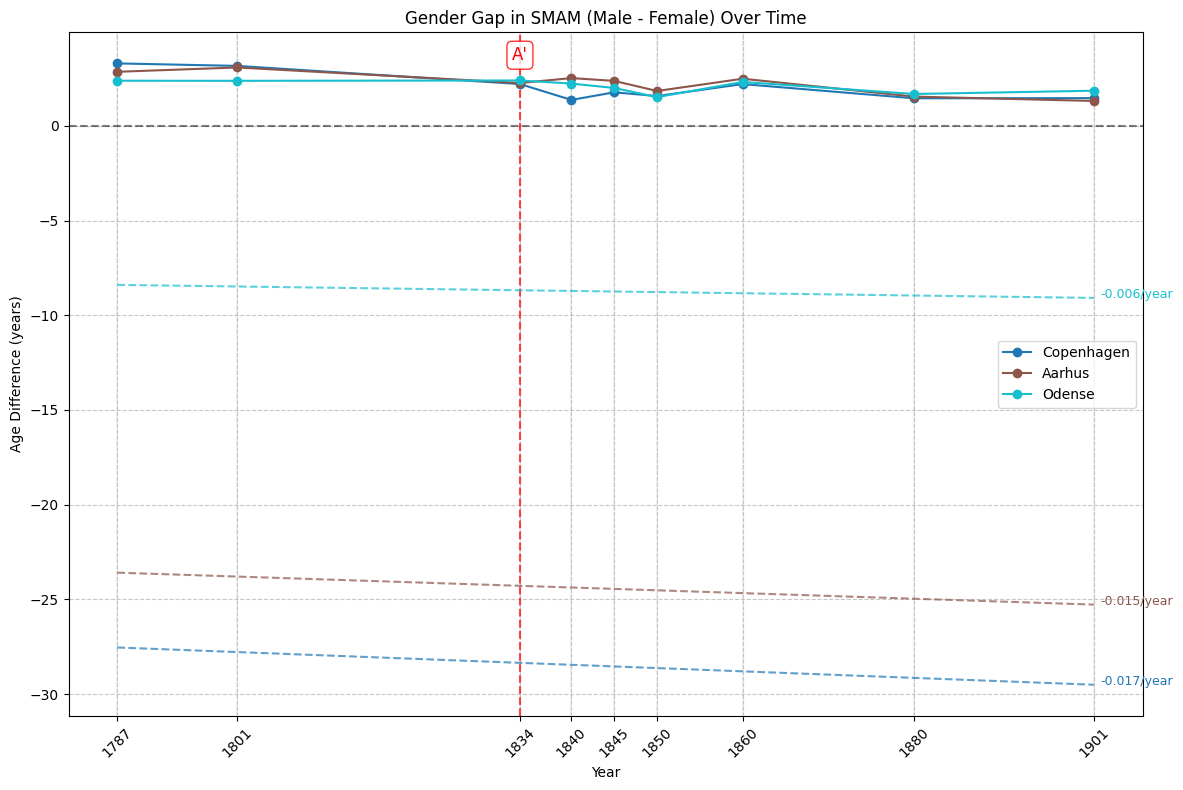

In [11]:
def analyze_gender_gap_significance(temporal_stats, county_names):
    """
    Analyze the gender gap in SMAM (Male - Female) and determine if
    changes in this gap are statistically significant.
    
    Args:
        temporal_stats: DataFrame with SMAM data
        county_names: List of counties to analyze
    
    Returns:
        Dictionary with gender gap analysis results
    """
    from scipy import stats
    import numpy as np
    
    results = {}
    
    for county in county_names:
        results[county] = {}
        
        # Extract data for this county
        county_data = temporal_stats[temporal_stats['county'] == county]
        
        # Find years with data for both genders
        female_data = county_data[county_data['gender'] == 'female']
        male_data = county_data[county_data['gender'] == 'male']
        
        female_years = set(female_data['year'])
        male_years = set(male_data['year'])
        common_years = sorted(female_years.intersection(male_years))
        
        if len(common_years) < 2:
            results[county] = {
                'enough_data': False,
                'message': f"Insufficient matched gender data for {county}"
            }
            continue
        
        # Calculate gender gap for each year
        gap_data = []
        for year in common_years:
            female_smam = female_data[female_data['year'] == year]['smam'].values[0]
            male_smam = male_data[male_data['year'] == year]['smam'].values[0]
            gap = male_smam - female_smam
            gap_data.append({'year': year, 'gap': gap})
        
        gap_df = pd.DataFrame(gap_data)
        
        # Overall trend in the gender gap
        years = gap_df['year'].values
        gaps = gap_df['gap'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, gaps)
        
        # First to last year change in gap
        first_year_gap = gap_df.iloc[0]['gap']
        last_year_gap = gap_df.iloc[-1]['gap']
        absolute_change = last_year_gap - first_year_gap
        percentage_change = (absolute_change / first_year_gap) * 100 if first_year_gap != 0 else np.nan
        
        # Statistical significance of the change in gap
        # If we have enough data points, we can test for a trend
        trend_significant = p_value < 0.05
        
        # Calculate mean gap before and after midpoint (if enough data)
        if len(common_years) >= 4:
            midpoint_idx = len(common_years) // 2
            midpoint_year = common_years[midpoint_idx]
            
            early_gaps = gap_df[gap_df['year'] < midpoint_year]['gap']
            late_gaps = gap_df[gap_df['year'] >= midpoint_year]['gap']
            
            if len(early_gaps) > 0 and len(late_gaps) > 0:
                early_mean_gap = early_gaps.mean()
                late_mean_gap = late_gaps.mean()
                mean_gap_change = late_mean_gap - early_mean_gap
                
                # T-test for change in mean gap
                t_stat, t_p_value = stats.ttest_ind(early_gaps, late_gaps, equal_var=False)
                mean_change_significant = t_p_value < 0.05
            else:
                early_mean_gap = np.nan
                late_mean_gap = np.nan
                mean_gap_change = np.nan
                t_stat = np.nan
                t_p_value = np.nan
                mean_change_significant = False
        else:
            midpoint_year = np.nan
            early_mean_gap = np.nan
            late_mean_gap = np.nan
            mean_gap_change = np.nan
            t_stat = np.nan
            t_p_value = np.nan
            mean_change_significant = False
        
        results[county] = {
            'enough_data': True,
            'gap_data': gap_df,
            'common_years': common_years,
            'first_year': common_years[0],
            'last_year': common_years[-1],
            'first_year_gap': first_year_gap,
            'last_year_gap': last_year_gap,
            'absolute_change': absolute_change,
            'percentage_change': percentage_change,
            'slope': slope,
            'slope_p_value': p_value,
            'trend_significant': trend_significant,
            'r_squared': r_value**2,
            'midpoint_year': midpoint_year,
            'early_mean_gap': early_mean_gap,
            'late_mean_gap': late_mean_gap,
            'mean_gap_change': mean_gap_change,
            't_statistic': t_stat,
            't_p_value': t_p_value,
            'mean_change_significant': mean_change_significant
        }
    
    return results

def print_gender_gap_results(gap_results, county_map=None):
    """
    Print the results of the gender gap analysis in a clear format
    """
    if county_map is None:
        county_map = {
            'københavn': 'Copenhagen',
            'århus': 'Aarhus',
            'odense': 'Odense'
        }
    
    print("=== GENDER GAP IN SMAM ANALYSIS ===\n")
    
    for county, results in gap_results.items():
        int_county = county_map.get(county, county)
        print(f"\n{int_county}:")
        
        if not results['enough_data']:
            print(f"  {results['message']}")
            continue
        
        print(f"  First year ({results['first_year']}) gap: {results['first_year_gap']:.2f} years")
        print(f"  Last year ({results['last_year']}) gap: {results['last_year_gap']:.2f} years")
        print(f"  Absolute change in gap: {results['absolute_change']:.2f} years")
        
        if not np.isnan(results['percentage_change']):
            print(f"  Percentage change in gap: {results['percentage_change']:.2f}%")
        
        # Overall trend analysis
        print(f"\n  Trend Analysis:")
        print(f"    Rate of change in gap: {results['slope']:.4f} years/year")
        print(f"    Trend p-value: {results['slope_p_value']:.4f}")
        print(f"    Trend significant: {'Yes' if results['trend_significant'] else 'No'}")
        print(f"    R-squared: {results['r_squared']:.4f}")
        
        # Before/after analysis (if available)
        if not np.isnan(results['midpoint_year']):
            print(f"\n  Before/After {int(results['midpoint_year'])} Comparison:")
            print(f"    Early period mean gap: {results['early_mean_gap']:.2f} years")
            print(f"    Late period mean gap: {results['late_mean_gap']:.2f} years")
            print(f"    Change in mean gap: {results['mean_gap_change']:.2f} years")
            print(f"    T-statistic: {results['t_statistic']:.2f}")
            print(f"    T-test p-value: {results['t_p_value']:.4f}")
            print(f"    Mean change significant: {'Yes' if results['mean_change_significant'] else 'No'}")
        
        # Table of values by year for reference
        print("\n  Year-by-Year Gender Gap:")
        print(f"    {'Year':<8} | {'Gap (years)':<10}")
        print(f"    {'-'*8} | {'-'*10}")
        
        for _, row in results['gap_data'].iterrows():
            print(f"    {int(row['year']):<8} | {row['gap']:<10.2f}")
    
    print()

def visualize_gender_gap_changes(gap_results, county_map=None):
    """
    Create visualizations showing changes in the gender gap over time
    """
    if county_map is None:
        county_map = {
            'københavn': 'Copenhagen',
            'århus': 'Aarhus',
            'odense': 'Odense'
        }
    
    # Create figure for gender gap trends
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(gap_results)))
    
    for i, (county, results) in enumerate(gap_results.items()):
        if not results['enough_data']:
            continue
            
        int_county = county_map.get(county, county)
        gap_df = results['gap_data']
        
        # Plot the actual gap values
        ax.plot(gap_df['year'], gap_df['gap'], marker='o', label=int_county, color=colors[i])
        
        # Plot the trend line
        years = gap_df['year'].values
        slope = results['slope']
        intercept = results['r_squared'] > 0.1 and slope * years[0] + (gap_df['gap'].values[0] - slope * years[0])
        
        if results['r_squared'] > 0.1:  # Only show trend if it explains some variance
            trend_years = np.array([years.min(), years.max()])
            trend_values = slope * trend_years + intercept
            ax.plot(trend_years, trend_values, '--', color=colors[i], alpha=0.7)
            
            # Annotate with trend slope
            ax.annotate(f"{slope:.3f}/year", 
                       xy=(years.max(), slope * years.max() + intercept),
                       xytext=(5, 0), textcoords='offset points',
                       fontsize=9, color=colors[i])
        
        # Highlight Copenhagen 1834 with a vertical line if in data
        if county == 'københavn' and 1834 in gap_df['year'].values:
            highlight_year = 1834
            ax.axvline(x=highlight_year, color='red', linestyle='--', alpha=0.7)
            ax.annotate("A'", 
                       xy=(highlight_year, ax.get_ylim()[1]),
                       xytext=(0, -10), textcoords='offset points',
                       fontsize=12, color='red', ha='center', va='top',
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
    
    ax.set_title('Gender Gap in SMAM (Male - Female) Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Age Difference (years)')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best')
    
    # Ensure x-axis shows all years
    all_years = sorted(set(year for county in gap_results 
                          if gap_results[county]['enough_data']
                          for year in gap_results[county]['gap_data']['year']))
    
    ax.set_xticks(all_years)
    ax.tick_params(axis='x', rotation=45)
    
    # Add vertical reference lines for each year
    for year in all_years:
        ax.axvline(x=year, color='lightgray', linestyle='-', alpha=0.3, zorder=0)
    
    plt.tight_layout()
    return fig

# Usage example
gender_gap_results = analyze_gender_gap_significance(temporal_stats, county_names)
print_gender_gap_results(gender_gap_results)
gap_fig = visualize_gender_gap_changes(gender_gap_results)
plt.show()